In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
import torch; import torch.nn as nn; import torch.nn.functional as F

## Overview

This notebook aims to develop intuition for understanding deep neural networks as an extension and generalization of familiar linear-regression frameworks. 

We begin by conceptualizing linear regression models as single-layer neural networks of *basis functions* (or *features*). Then we demonstrate how adding layers and activation functions allows deep neural networks to learn optimal basis functions (or *feature representations*) dynamically through backpropogation with gradient descent. We also explore some of the strengths and weaknesses of this technique. .

Next we discuss the capacity of deep neural networks for reducing dimensionality, providing direct benefits over the linear-regression framework by reducing the number of basis functions that must be fit (and therefore reducing the dimensionality). Finally, we extend the powerful findings about dimensionality reduction to notions of feature-spaces, semantic representations, and the manifold hypothesis.

## 1. Thinking in Basis Functions

### General Form of OLS

Let's begin by recalling the familiar form of OLS:
$$
\hat{y} = \beta_0 + x_1\beta_1 + x_2\beta_2 + \cdots + x_M\beta_M \\ \ \\
\hat{y} = \sum_{j=0}^M x_j\beta_j
$$
Where $x_0=1$ such that $\beta_j$ is an intercept coefficient. We will refer to this intercept as the ***Bias*** from now on. For a system of equations, we may express this equation with vectors and matrices as:
$$\bf \hat{y} = X\hat{\beta}$$
The vector $\bf \beta$ has a convenient form that is analytically derivable under OLS:
$$
\bf \hat{\beta} = (X^\intercal X)^{-1}X^\intercal y
\implies \hat{y} = X(X^\intercal X)^{-1}X^\intercal y = X\hat{\beta}
$$

**Aside**: The matrix $\bf X(X^\intercal X)^{-1}X^\intercal$ is often called the "hat matrix" because it "puts a hat on $y$" and is denoted $\bf H$. This matrix is an *orthogonal projection*; specifically, it orthogonally projects $y$ onto the vector subspace spanned by the *row* correlation matrix of $\bf X$ (i.e. $\bf XX^\intercal$). For more on this, look up singular-value decomposition.

### Introducing Basis Functions

Ok, so this expresses an optimized linear approximation of $y$ given an $[N\times M]$ design matrix $\bf X$ comprised of $n$ observations (rows) and $m$ predictor variables (columns). We may begin to introduce non-linearity by expressing the predictor variables as non-linear *functions*. For instance, a very familiar regression model is polynomial regression:
$$\hat{y} = \beta_0 + x_1\beta_1 + x_1^2\beta_2$$
This regression is a linear combination of $x_1$ and a nonlinear function of $x_1$, $f(x_1)=x_1^2$. This functional expression is called a *feature* and it allows us to model linear relationships for *non-linear* datasets. We will denote such functions of input variables $\phi_i(x_i)$ and call them *basis functions*.

''

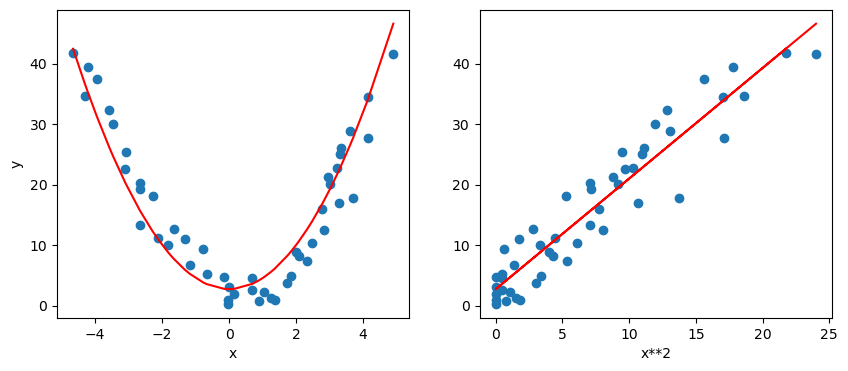

In [22]:
# example polynomial regression
import kagglehub
path = kagglehub.dataset_download("mirajdeepbhandari/polynomial-regression")

df = pd.read_csv(path +"\\Ice_cream selling data.csv")
x = df.iloc[:, 0].values.reshape(-1, 1)
y = df.iloc[:, 1].values.reshape(-1, 1)
model = LinearRegression().fit(x**2, y)
yh = model.predict(x**2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.scatter(x, y)
ax1.plot(x, yh, color="red")

xb = x**2
ax2.set_xlabel('x**2')
ax2.scatter(xb, y)
ax2.plot(xb, yh, color="red") 
plt.show();

We will deviate one more step from the OLS notation and replace the coefficient estimates $\beta_i$ with the notation $w_i$ and henceforth refer to them as *weights*. Then we may express a simple linear model as:
$$\hat{y} = \sum_{j=0}^M w_j\phi_j(x_j)$$
A more general form is:
$$\hat{y} = \sum_{j=0}^M w_j\phi_j(\bf x)$$
Where the bold-faced $\bf x$ is a vector of length $N$ representing one observation from the input data. This reflects how basis functions need not be limited to include only one input variable, and how the number of basis functions is not limited to the number of input variables. For instance, we may be interested in *interaction terms* which are basis functions of two or more input variables. E.g.
$$\hat{y} = w_0 + x_1w_1 + x_2w_2 + x_1x_2w_3 = w_0\phi_0(\mathbf{x}) + w_1\phi_1(\mathbf{x}) + w_2\phi_2(\mathbf{x}) + w_3 \phi_3(\mathbf{x})$$
Where $\phi_0(\mathbf{x}) = 1$, $\phi_1(\mathbf{x}) = x_1$,  $\phi_2(\mathbf{x}) = x_2$, $\phi_3(\mathbf{x}) = x_1x_2$.

For a system of equations we may express this in matrix form as:
$$\bf \hat{y} = \Phi w$$
Where $\bf \Phi$ is an $[N \times M]$ matrix with elements gen by $\Phi_{nj} = \phi_j(\mathbf{x}_n)$

**Aside**: When the distribution of the response variable $y$ conditioned upon the input variables in $\bf X$ is Gaussian with zero-mean and constant variance (the axiomatic assumptions of OLS), then maximum likelihood expression for $\mathbf{w}_{ML}$ is:
$$\mathbf{w}_{ML} = \bf (\Phi^\intercal \Phi)^{-1}\Phi^\intercal y$$

### Generalizing to GLMs

Ok, one last step to broaden this expression to fit general linear models (GLMs); we need to add a *link* function:
$$\hat{\mathbf{y}} = h(\bf \Phi w)$$
Now, the predicted response $\bf \hat{y}$ is no longer a linear function of the weights and features, for nonlinear $h(\cdot)$, it is a nonlinear function. The inverse $h^{-1}(\cdot)$ is called the *link function* in statistical learning literature. In ML literature, it is called the *activation function* and $\bf \Phi w$ is called the *preactivation* denoted $\bf a$.

In summary, we've obtained the expression:
$$\hat{y}_n = h(a_n) = h\big(\sum_{j=0}^M w_j\phi_j(\mathbf{x}_n)\big)$$

### More Examples

Let's consider a few basis functions:
$$\text{Gaussian Basis Function:} \ \ \phi(x) = \exp\bigg(\frac{-(x - \mu)^2}{2\sigma^2} \bigg) \ \implies \ \phi(x) \in [0, 1]$$
$$\text{Sigmoid Basis Function:} \ \ \phi(x) = \sigma(x) = \frac{1}{1 + e^{-x}} \ \implies \phi(x) \in [0, 1] $$
$$\text{tanh Basis Function:} \ \ \phi(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = 2\sigma(2x) - 1 \ \implies \ \phi(x) \in [-1, 1]$$

In [2]:
def gauss_basis(x): return np.exp(-((x - x.mean(axis=0))**2) / (2 * x.var(axis=0)))
def sigmoid(x):     return 1 / (1 + np.exp(-x))
def tanh(x):        return 2 * sigmoid(2*x) - 1

Let's look at tanh first:

In [3]:
from sklearn.datasets import make_blobs
import seaborn as sns
X, y = make_blobs(
    n_samples=100, 
    centers=[(0, 7.5), (-6, -2), (-4, 5)], 
    n_features=2, 
    cluster_std=0.6
)
x1, x2 = X[:, 0], X[:, 1]
y[y == 0] = 1

In [4]:
def decision_boundary(X, y):
    mod = LogisticRegression(penalty=None)
    mod.fit(X, y)
    acc = accuracy_score(y, mod.predict(X))

    h = mod.predict_log_proba(X)[:, 1]
    b = mod.intercept_
    w1, w2 = mod.coef_[0]
    h = sigmoid(h)

    return (h - w1 * X[:, 0] - b) / w2, acc

def print_plot(X2, y):
    fx, acc = decision_boundary(X, y)     # decision boundary before change of basis
    fx2, acc2 = decision_boundary(X2, y)  # decision boundary after change of basis

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.set_title(f"Before Change of Basis, Acc: {acc:,.2f}")
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax1)
    sns.lineplot(x=X[:, 0], y=fx, ax=ax1)

    ax2.set_title(f"After Change of Basis, Acc: {acc2:,.2f}")
    ax2.set_xlabel('phi(x_1)')
    ax2.set_ylabel('phi(x_2)')
    sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=y, ax=ax2)
    sns.lineplot(x=X2[:, 0], y=fx2, ax=ax2)

    plt.show();

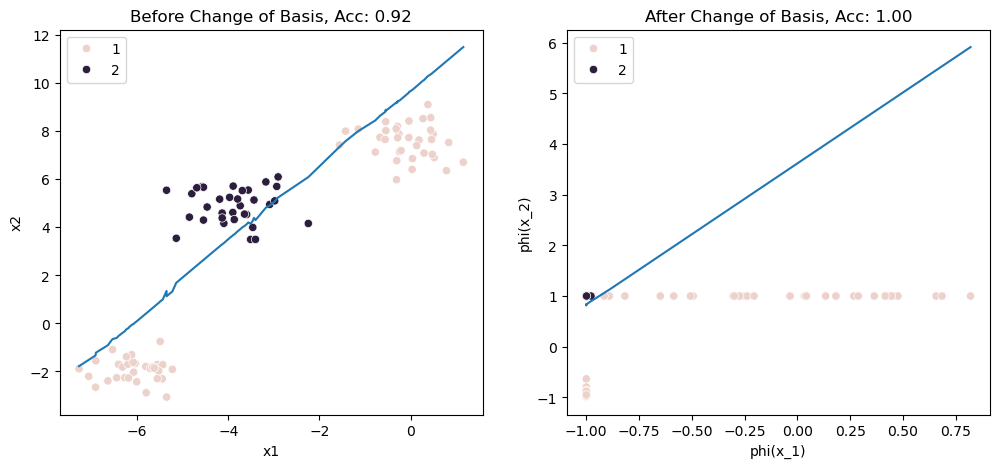

In [5]:
print_plot(tanh(X), y)

The hyperbolic tangent is a homeomorphic function - i.e. *it's reversible*! So, we can plot the decision boundary that we fit in the $\phi(x_1), \phi(x_2)$ space in the $x_1, x_2$ space:
$$\text{tanh}^{-1}(x) = \sigma^{-1}\bigg(\frac{x + 1}{2}\bigg)\frac{1}{2}$$

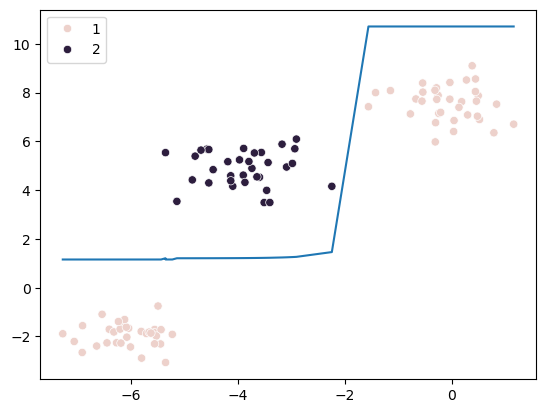

In [6]:
def logit(x): return np.log(x / (1 - x))
def inv_tanh(x): return logit((x + 1) / 2) / 2

fx2 = decision_boundary(tanh(X), y)[0]
fx2[fx2 > 1] = 0.999999999
fx2[fx2 < -1] = -0.9999999

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.lineplot(x=X[:, 0], y=inv_tanh(fx2));

Now let's look at the Gaussian basis function:

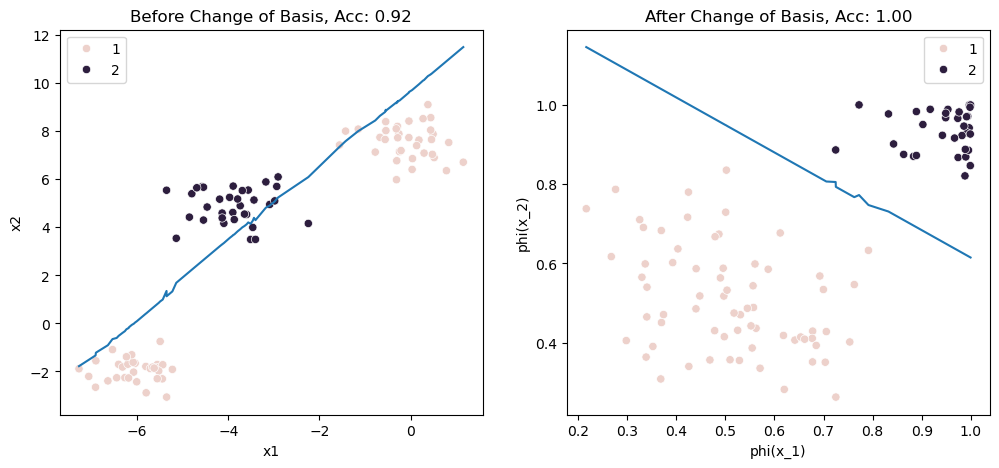

In [7]:
print_plot(gauss_basis(X), y)

Unfortunately, the Gaussian basis function is *non-homeomorphic* - i.e. it isn't reversible. Specifically, this is because it isn't injective, it maps multiple values of $x$ onto the same value. For example, $-2$ and $2$ both get mapped onto the same value.
$$\phi^{-1}(x) = \pm\sqrt{-2\sigma^2\ln x} + \mu$$
Also, this is actually defined on the complex space $\mathbb{C}$ not $\reals$ because of the negative term in the square root.

So, to see the decision boundary in the original $x_1, x_2$ space, we need to use numerical approximation techniques. I won't fuss with that here, but if we could visualize the boundary in $x_1, x_2$, it would appear as a ring around the class $2$ blob. E.g.:

<img src="images/bishop_gauss_basis.png">

*Deep Learning, Foundations and Concepts*, Bishop

## 2. Linear Regression Models are Single-Layer Neural Networks*

The most simple expression of a neural network is that of a *feed-forward* network (aka. *multi-layered perceptron*). This is nothing more than a system of $D$ linear equations with non-linear activation functions. For "one-layer" this takes the form:
$$z_d^{(1)} = h(a_d^{(1)}) = h\big(\sum_{j=0}^M w_{dj}^{(1)} x_j \big)$$
Where $a_d^{(1)}$ denotes the $d^{\text{th}}$ preactivation for the layer $1$ and $z_d^{(1)}$ denotes the $d^{\text{th}}$ activation for layer $1$. The activation function $h(\cdot)$ is typically non-linear, however, if $h(a) = a$ (i.e. is the identity link function), then the system is perfectly linear.

In matrix notation:
$$\mathbf{z}^{(1)} = h(\mathbf{a}^{(1)}) = h\bigg(\mathbf{X}\mathbf{w}^{(1)}\bigg)$$

In the parlance of deep-learning, these $D$ equations are called *hidden units* or *neurons*.

Note the similarity to the expression for a GLM derived in Part 1? The GLM formula is nothing more than a single-layered neural network with the inputs $x_j$ replaced with fixed basis functions $\phi_j(\mathbf{x})$:
$$z_d^{(1)} = h(a_d^{(1)}) = h\big(\sum_{j=0}^M w_{dj}^{(1)} \phi_j(\mathbf{x}) \big)$$

The most fundamental objective of a deep neural network, regardless of its complexity or architecture, is to *learn* these basis functions $\phi_j(\cdot)$ *from the data*.

Before moving on, let's quickly note the expression for layers after the first:\
We may add a second layer with $K$ linear equations of the activations from the first layer:
$$z_k^{(2)} = h(a_k^{(2)}) = h\bigg(\sum_{d=0}^D w_{kd}^{(2)}z_d^{(1)}\bigg)$$
Later layers are similarly expressed:
$$z^{(\tau)} = h(a^{\tau}) = h\big(\sum w^{(\tau)}z^{(\tau-1)}\big)$$

We may express this compactly with matrices as:
$$\mathbf{z}^{(2)} = h\bigg(h\big(\mathbf{X}\mathbf{W}^{(1)}\big)\mathbf{W}^{(2)}\bigg)$$

**Aside**: I put an asterisk on the header for this section because our choice of fixed basis function may not be exactly reproducible through a neural network. Neural networks *learn* basis functions through a numerical optimization technique called *gradient descent*. A result of this optimization is that any function learned by the network will be *homeomorphic*. Thus, we won't be able to learn the Gaussian basis function, or even a simple polynomial basis function like $x^2$, at least not directly because they are not homeomorphic. What we are able to do is approximate them to an arbitrary degree of accuracy for a *finite* range of input values.

I'll leave the definition of a homeomorphism here for reference. It remains important if/when we get to discussing the manifold hypothesis:

The mapping $\mathbf{\Phi}: \mathcal{V} \rightarrow \mathcal{W}$ is a homeomorphism if:
1. It is bijective
2. It is continuous
3. Its inverse $\mathbf{\Phi}^{-1}$ is also continuous

***1. Bijective:***

Let $\mathcal{V}$ and $\mathcal{W}$ be vector sets, then $\mathbf{\Phi}: \ \mathcal{V} \rightarrow \mathcal{W}$ is a mapping between the sets. This mapping is:
- ***Injective*** if: $$\forall \ \mathbf{x}, \mathbf{y} \in \mathcal{V} \ : \ \mathbf{\Phi(x)} = \mathbf{\Phi(y)} \ \implies \mathbf{x} = \mathbf{y} \\ \text{the contrapositive is:} \ \forall \ \mathbf{x}, \mathbf{y} \in \mathcal{V} \ : \ \mathbf{\Phi(x)} \ne \mathbf{\Phi(y)} \ \implies \mathbf{x} \ne \mathbf{y}$$
    - Written out: a function is injective if it maps distinct elements in the domain of $\mathcal{V}$ to distinct elements in the codomain $\mathcal{W}$
    - A consequence of injectivity is that different inputs will *always* lead to different outputs
    - E.g. $f(x) = 2x$ is injective
    - E.g. $f(x) = x^2$ is **not** injective -- $f(2) = f(-2) = 4$
- ***Surjective*** if: $$\mathbf{\Phi}(\mathcal{V}) = \mathcal{W} \\ \ \\ \text{equivalently:} \ \forall \ \mathbf{y} \in \mathcal{W}, \ \exists \mathbf{x} \in \mathcal{V} \ : \ \mathbf{\Phi}(\mathbf{x}) = \mathbf{y}$$
    - Written out: a function is surjective if it maps points from the domain of $\mathcal{V}$ onto *all* points in the codomain $\mathcal{W}$
    - Geometrically, this means that the mapping  allows for no gaps or missing points
    - E.g. $f(x) = x^2$ is **not** surjective onf $\reals$ because it never reaches any negative numbers

A function (mapping) is **Bijective** if it is both injective and surjective.

## 3. Neural-Networks Learn Basis Functions from Input Data

The crucial thing to note is how our basis functions in the examples from Part 1 changed the bases to represent the input data within a new feature space, allowing us to fit a regression or decision boundary as a linear curve in the feature space despite being non-linear in the input space. Neural networks simply learn (through gradien descent), a sufficient approximation to this feature space that enables a linear curve to be fit. The network "learns" this approximation be stretching and bending the feature space over-and-over until a linear curve may be fit. In the case of classification, this means that the space is stretched and bent until the classes are linearly separable.

In [8]:
from collections import OrderedDict

class MLP(nn.Module):
    def __init__(self, activation, n_in, n_hidden, n_out, n_layers):
        super().__init__()
        self.losses = []
        self.activation = nn.ReLU() if activation == 'relu' else nn.Tanh()

        # input layer
        layers_dict = OrderedDict([
            ('l1', nn.Linear(n_in, n_hidden)),
            ('act1', self.activation),
        ])

        # hidden layers
        for i in range(2, n_layers):
            layers_dict.update([
                (f'l{i}', nn.Linear(n_hidden, n_hidden)), 
                (f'act{i}', self.activation)
            ])
        
        # output layer
        layers_dict.update([
            (f'l{n_layers}', nn.Linear(n_hidden, n_out)),
            # (f'act{n_layers}', self.activation)
        ])

        self.layers = nn.Sequential(layers_dict)        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        return self.layers(X)

    def train(self, X, y, epochs: int=1000):
        X = torch.FloatTensor(X)
        y = torch.Tensor(y).type(torch.LongTensor)
        y = y - 1  # small fix to convert classes to 0, 1 from 1, 2

        for epoch in range(epochs):
            logits = self.layers(X)
            loss = F.cross_entropy(logits, y)
            self.losses.append(loss.item())

            self.optimizer.zero_grad()  # clear gradients
            loss.backward()             # update gradients
            self.optimizer.step()       # update weights

    def predict(self, X):
        X = torch.FloatTensor(X)
        logits = self.forward(X)
        probs = F.softmax(logits, dim=1)
        return torch.argmax(probs, dim=1)

    def evaluate(self, X, y):
        X = torch.FloatTensor(X)
        y = torch.Tensor(y).type(torch.LongTensor)
        y = y - 1  # small fix to convert classes to 0, 1 from 1, 2

        preds = self.predict(X)
        acc = (preds == y).sum().item() / len(y)
        return acc

In [15]:
model = MLP(activation='tanh', n_in=2, n_hidden=2, n_out=2, n_layers=2)
model.train(X, y, epochs=5000)
model.evaluate(X, y)

1.0

In [16]:
for name, param in model.named_parameters():
    print(name, param.data)

layers.l1.weight tensor([[ 0.9435,  0.3523],
        [-0.3011, -1.0168]])
layers.l1.bias tensor([-0.3066, -0.7338])
layers.l2.weight tensor([[ 2.1030,  2.6883],
        [-1.7521, -1.9286]])
layers.l2.bias tensor([ 1.9988, -2.6469])


First Layer Transformation


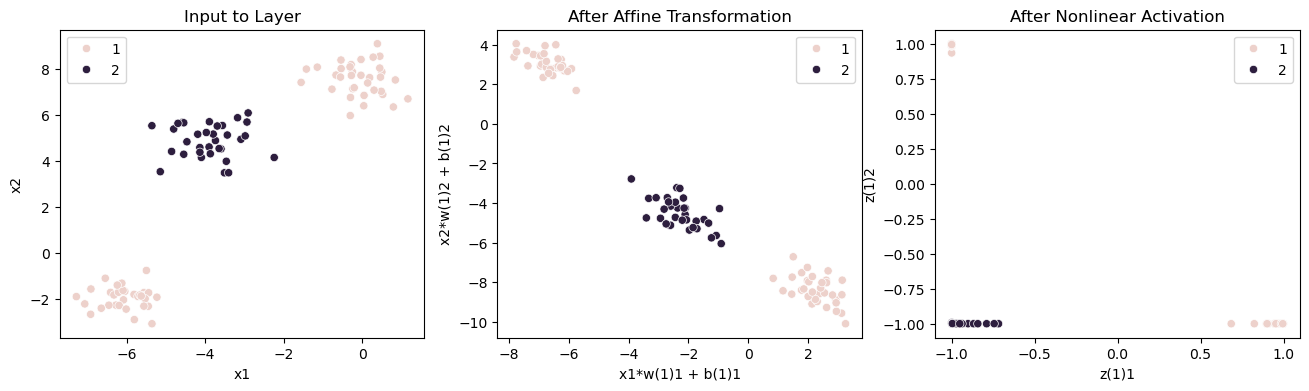

In [27]:
print("First Layer Transformation")
stretch = model.layers.l1.weight.data.numpy()
shift = model.layers.l1.bias.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.set_title('Input to Layer')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax1)

ax2.set_title('After Affine Transformation')
ax2.set_xlabel('x1*w(1)1 + b(1)1')
ax2.set_ylabel('x2*w(1)2 + b(1)2')
X1 = X @ stretch.T + shift
sns.scatterplot(x=X1[:, 0], y=X1[:, 1], hue=y, ax=ax2)

ax3.set_title("After Nonlinear Activation")
X1t = tanh(X1)
ax3.set_xlabel('z(1)1')
ax3.set_ylabel('z(1)2')
sns.scatterplot(x=X1t[:, 0], y=X1t[:, 1], hue=y, ax=ax3)
plt.show()

Second Layer Transformation


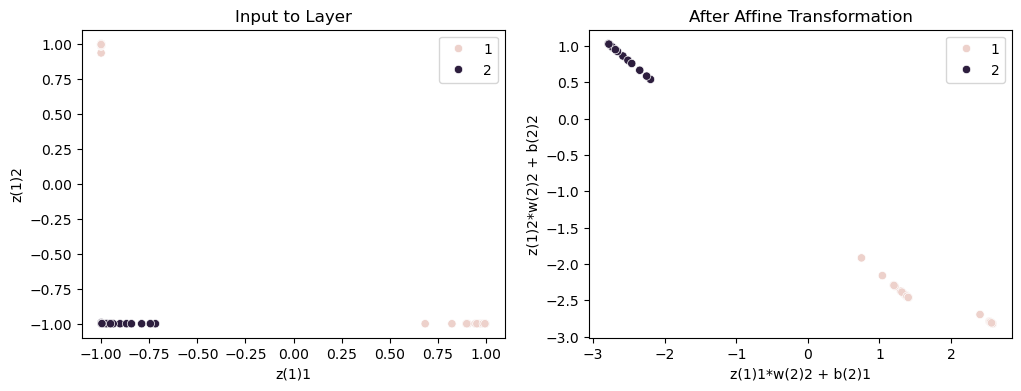

In [28]:
print("Second Layer Transformation")
stretch = model.layers.l2.weight.data.numpy()
shift = model.layers.l2.bias.data.numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Input to Layer')
ax1.set_xlabel('z(1)1')
ax1.set_ylabel('z(1)2')
sns.scatterplot(x=X1t[:, 0], y=X1t[:, 1], hue=y, ax=ax1)

ax2.set_title('After Affine Transformation')
ax2.set_xlabel('z(1)1*w(2)2 + b(2)1')
ax2.set_ylabel('z(1)2*w(2)2 + b(2)2')
X2 = X1t @ stretch.T + shift
sns.scatterplot(x=X2[:, 0], y=X2[:, 1], hue=y, ax=ax2)
plt.show()

This is sort of tough to visualize... But I think that the intuition is there. We can think of each layer of the neural network as doing three thing:
1. Rotating and stretching the space, through the weights $\mathbf{w}^{(\tau)}$
2. Shifting the space, through the bias $\mathbf{b}^{(\tau)}$ otherwise denoted $\mathbf{w}_0^{(\tau)}$
3. *Curving* the space, through a non-linear activation function $h(\cdot)$, like $\text{tanh}(\cdot)$

By stacking these transformations we may *approximate* any function within a finite interval of input values to an arbitrary degree of accuracy. This conclusion is the essence of **The Universal Approximation Theorem**.

An excellent demonstration of these transformations is available [here](https://cs.stanford.edu/people/karpathy/convnetjs//demo/classify2d.html), I strongly encourage you check it out.

## Coda: Dimensionality

This notebook has gotten far too long to venture into discussions of dimensionality - the other (and perhaps greatest) strength of deep neural networks. However, I'd like to motivate the concept by noting the ability for the layers of the network to have a variable number of hidden units (equations). At the input layer, (i.e. layer $(1)$), we need as many hidden units as input variables (really, as many as linearly indpendent input variables). However, beginning with the second hidden layer, we can have an aribtrary number of hidden units. As we increase the number of hidden units, we increase the dimensions of the feature space. As we decrease the number of hidden units, we decrease the dimensions of the feature space. This flexibility has some very powerful results, including (unintuitively) the potential to radically *reduce* the dimensionality of a problem.